In [1]:
# Main library: https://square.github.io/pysurvival/index.html
#----------------------------Reproducible------------------------------------------
import numpy as np
import random as rn
import pandas as pd
import gc
import os

seed=0
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
rn.seed(seed)

#----------------------------Reproducible------------------------------------------

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from sklearn.model_selection import train_test_split
from pysurvival.models.semi_parametric import NonLinearCoxPHModel
from pysurvival.utils.metrics import concordance_index
from pysurvival.utils.display import integrated_brier_score
from pysurvival.utils.display import display_loss_values
from pysurvival.utils.display import compare_to_actual

from lifelines import KaplanMeierFitter
from matplotlib import pyplot as plt

import heapq
import seaborn as sns

In [2]:
def csv_read(p_path):
    pd_data=pd.read_csv(p_path, sep=',')
    column_names=pd_data.columns.values.tolist()
    print(column_names)
    return pd_data,column_names

def write_to_csv(p_data,p_path):
    dataframe = pd.DataFrame(p_data)
    dataframe.to_csv(p_path, mode='a',header=False,index=False,sep=',')
    del dataframe
    gc.collect()

In [3]:
data,column_names=csv_read('./data/survival_data_filtered_3.csv')

['NACCREAS', 'NACCREFR', 'BIRTHMO', 'BIRTHYR', 'SEX', 'HISPANIC', 'HISPOR', 'RACE', 'RACESEC', 'RACETER', 'PRIMLANG', 'EDUC', 'MARISTAT', 'NACCLIVS', 'INDEPEND', 'RESIDENC', 'HANDED', 'NACCNINR', 'NACCFAM', 'NACCMOM', 'NACCDAD', 'NACCFADM', 'NACCFFTD', 'ANYMEDS', 'NACCSTYR', 'NACCTIYR', 'MEMORY', 'ORIENT', 'JUDGMENT', 'COMMUN', 'HOMEHOBB', 'PERSCARE', 'CDRSUM', 'DECSUB', 'DECIN', 'COGMEM', 'COGJUDG', 'COGLANG', 'COGVIS', 'COGATTN', 'COGOTHR', 'NACCCOGF', 'COGMODE', 'DECAGE', 'BEAPATHY', 'BEDEP', 'BEVHALL', 'BEAHALL', 'BEDEL', 'BEDISIN', 'BEIRRIT', 'BEAGIT', 'BEPERCH', 'BEOTHR', 'NACCBEHF', 'BEMODE', 'MOGAIT', 'MOFALLS', 'MOTREM', 'MOSLOW', 'NACCMOTF', 'MOMODE', 'COURSE', 'FRSTCHG', 'NORMCOG', 'DEMENTED', 'NACCPPA', 'NACCBVFT', 'NACCLBDS', 'NACCTMCI', 'NACCMCIL', 'NACCMCIA', 'NACCMCIE', 'NACCMCIV', 'NACCMCII', 'IMPNOMCI', 'NACCALZD', 'NACCALZP', 'NACCLBDE', 'NACCLBDP', 'PARK', 'PSP', 'PSPIF', 'CORT', 'CORTIF', 'DOWNS', 'DOWNSIF', 'HUNT', 'HUNTIF', 'PRION', 'PRIONIF', 'BRNINJ', 'BRNINJIF

In [4]:
data

,NACCREAS,NACCREFR,BIRTHMO,BIRTHYR,SEX,HISPANIC,HISPOR,RACE,RACESEC,RACETER,...,NPBNKB,NACCFORM,NACCPARA,NACCCSFP,NPBNKF,NPFAUT,NACCDAGE,NACCINT,SurvivalTime,Event
0,0,1,3,14,1,0,4,0,2,0,...,0,1,1,1,0,0,45,43,300,True
1,0,2,2,13,1,0,4,0,0,0,...,1,0,1,0,0,0,49,10,431,False
2,1,1,11,27,1,0,4,0,2,0,...,1,1,1,0,0,0,31,37,343,False
3,1,1,3,42,0,0,4,0,2,0,...,1,1,1,0,0,0,19,32,0,False
4,0,1,2,51,0,0,4,0,2,0,...,1,1,1,0,0,0,9,10,73,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
624,1,1,3,15,1,0,4,0,2,0,...,0,1,1,0,0,0,44,59,93,True
625,0,1,11,36,1,0,4,0,2,0,...,1,0,1,0,0,0,23,4,0,False
626,0,0,2,33,0,0,4,0,2,0,...,1,1,1,1,0,2,28,23,222,False
627,1,1,6,28,0,0,4,0,2,0,...,0,1,1,0,0,0,32,9,156,True


In [5]:
Events=np.array(data.loc[:,'Event'])
print("%.2f%% samples are right censored in whole data." % (np.sum(~Events) * 100. / len(Events)))

58.82% samples are right censored in whole data.


In [ ]:
X=data.loc[:,'NACCREAS':'NACCINT']
y_=data.loc[:,'SurvivalTime':'Event']
y=np.array([(y__[1],y__[0]) for y__ in np.array(y_)], dtype=[('Event', 'bool'), ('SurvivalTime', '<f8')])

models=[]
structure = [ {'activation': 'BentIdentity', 'num_units': 150},  ]
seed_num=5
epoch_num=2000

for seed_i in np.arange(seed_num):

    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2, random_state=seed_i)

    time_train=y_train['SurvivalTime']
    event_train=y_train['Event']
    time_test=y_test['SurvivalTime']
    event_test=y_test['Event']

    # Building the model
    nonlinear_coxph = NonLinearCoxPHModel(structure=structure)
    nonlinear_coxph.fit(X_train, time_train, event_train, num_epochs = epoch_num,lr=1e-4, init_method='glorot_uniform')

    models.append(nonlinear_coxph)

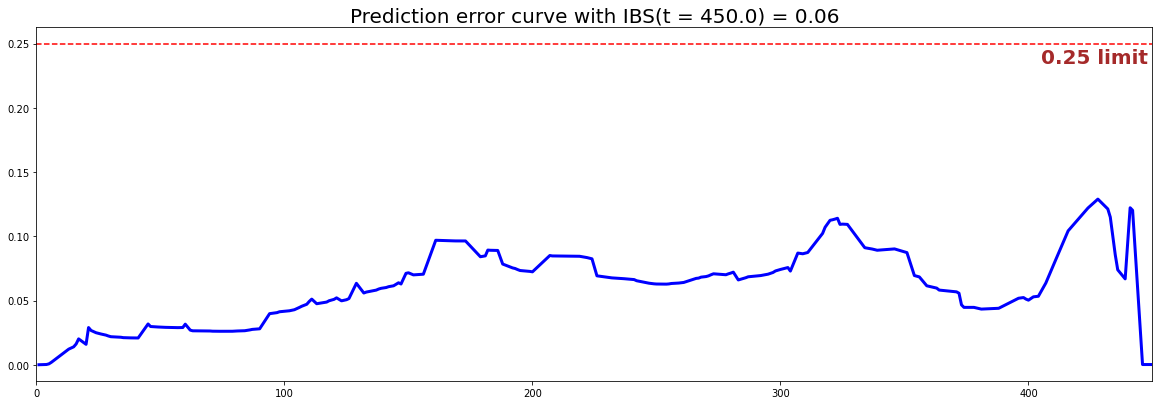

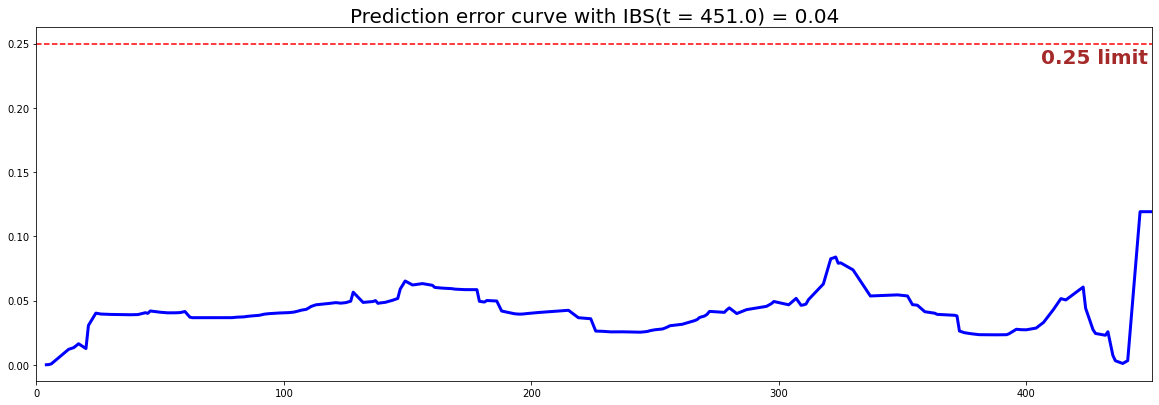

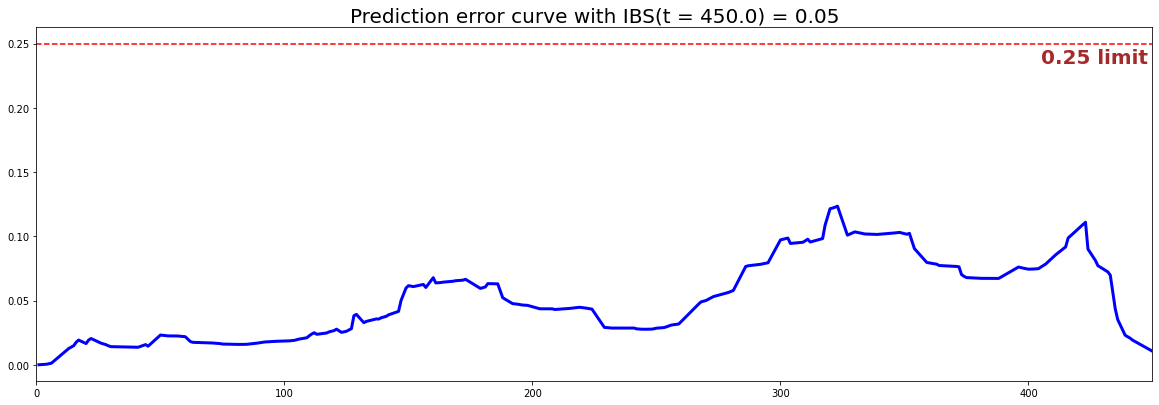

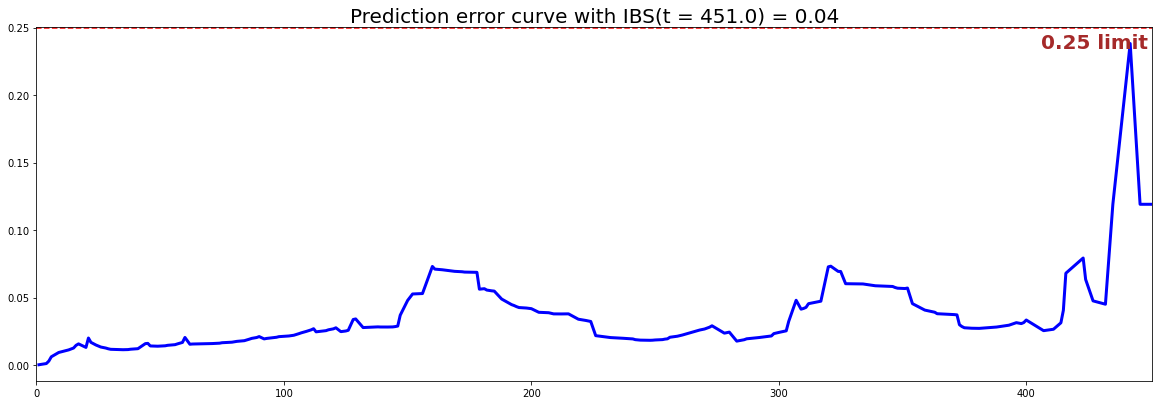

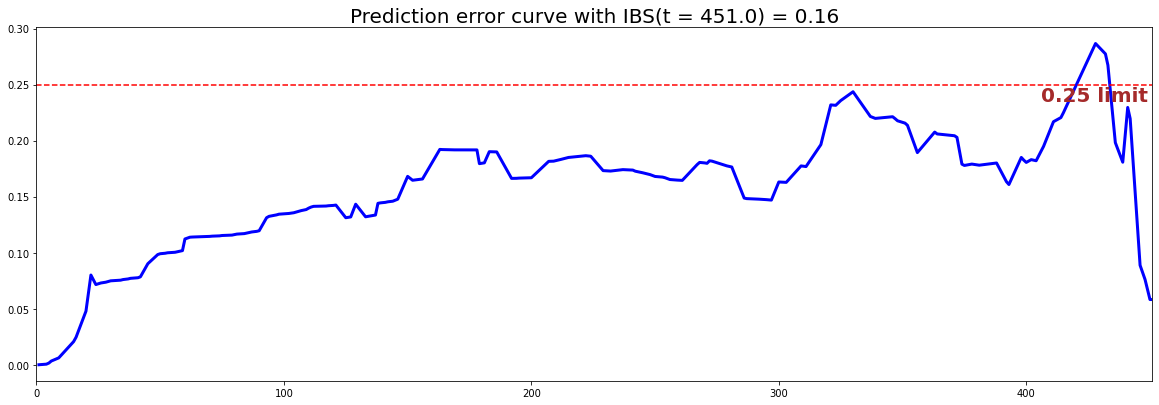

In [7]:
Loss_list=[]
C_index_list=[]
IBS_list=[]

for seed_i in np.arange(seed_num):
    model_used=models[seed_i]
    Loss_list.append(model_used.loss_values)
    
    # Model Performances
    c_index = concordance_index(model_used, X_test, time_test, event_test) #0.81
    #print('C-index: {:.2f}'.format(c_index))

    ibs = integrated_brier_score(model_used, X_test, time_test, event_test, t_max=None, figure_size=(20, 6.5) )
    #print('IBS: {:.2f}'.format(ibs))

    C_index_list.append(c_index)
    IBS_list.append(ibs)

In [8]:
p_path="./performance_CI.csv"
write_to_csv(np.array(C_index_list).reshape(1,np.array(C_index_list).shape[0]),p_path)
print(C_index_list)
print(np.mean(C_index_list))
print(np.std(C_index_list))

p_path="./performance_IBS.csv"
write_to_csv(np.array(IBS_list).reshape(1,np.array(IBS_list).shape[0]),p_path)
print(IBS_list)
print(np.mean(IBS_list))
print(np.std(IBS_list))

[0.8638415446107419, 0.9307871630423862, 0.8905176266789383, 0.9253829969999023, 0.708932983857419]
0.8638924630378775
0.08121247290300498
[0.06224925587212246, 0.04159653885782212, 0.05094023011022011, 0.03764852089616786, 0.1598986867140409]
0.07046664649007468
0.04551353369279046


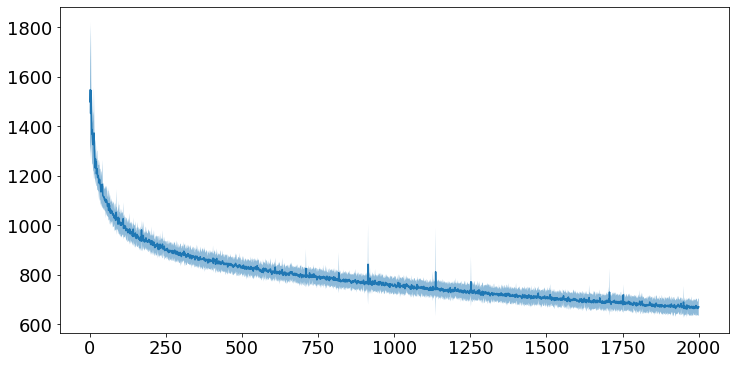

In [9]:
fig, ax = plt.subplots(figsize=(12, 6))
Loss_list_mean=np.mean(np.array(Loss_list),axis=0)
Loss_list_std=np.std(np.array(Loss_list),axis=0)

max_loss=int(np.max(Loss_list_mean))+1
min_loss=int(np.min(Loss_list_mean))
step=int(max_loss/5)

ax.plot(np.arange(epoch_num)+1, Loss_list_mean, '-')
ax.fill_between(np.arange(epoch_num)+1, Loss_list_mean - Loss_list_std, Loss_list_mean + Loss_list_std, alpha=0.5)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

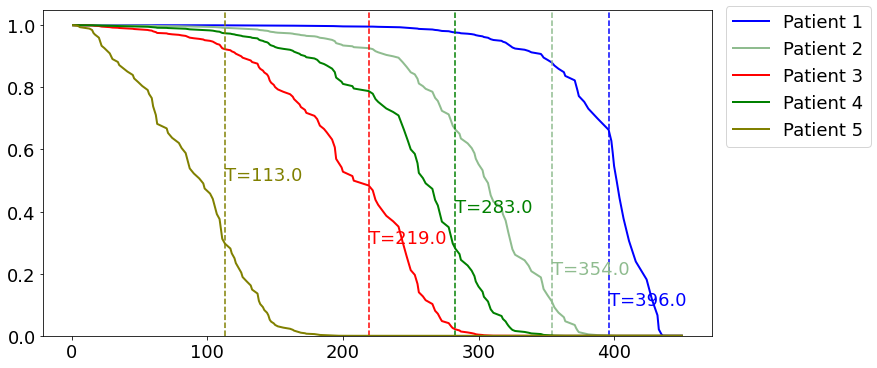

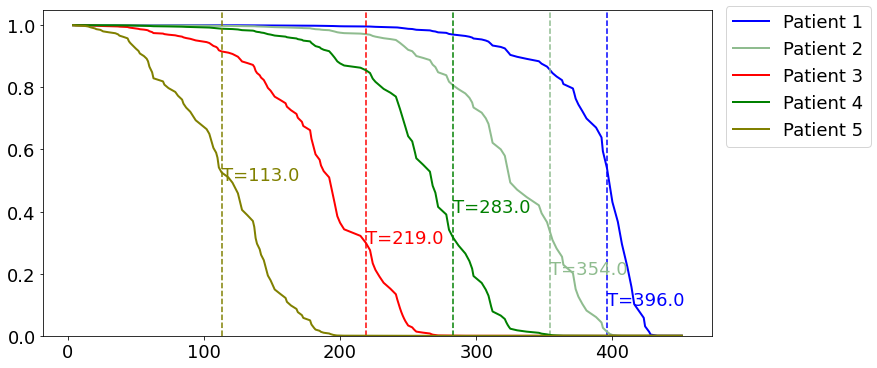

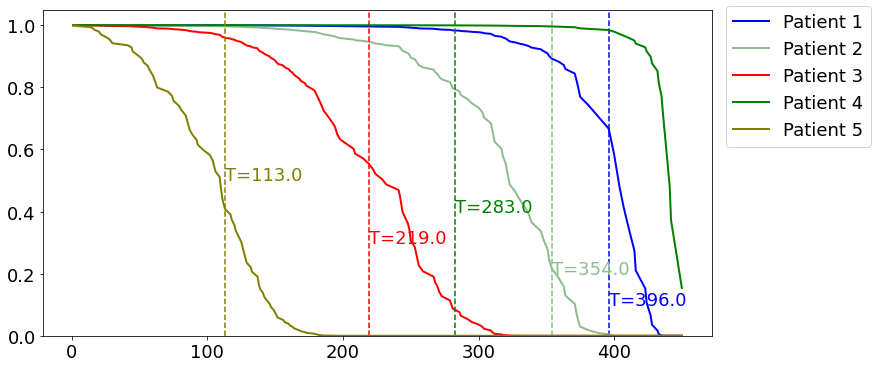

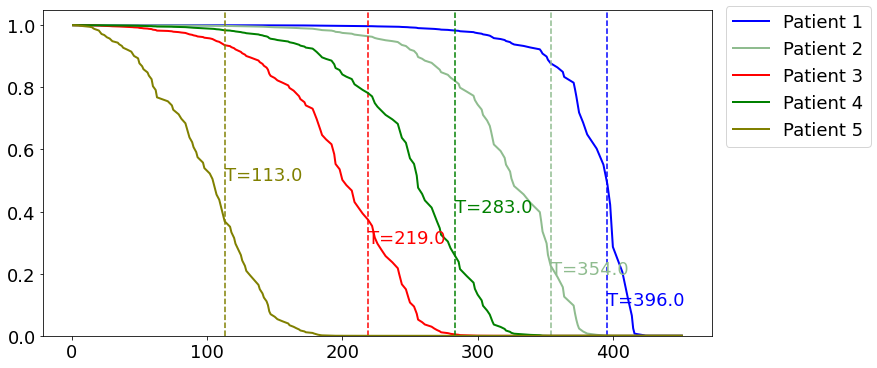

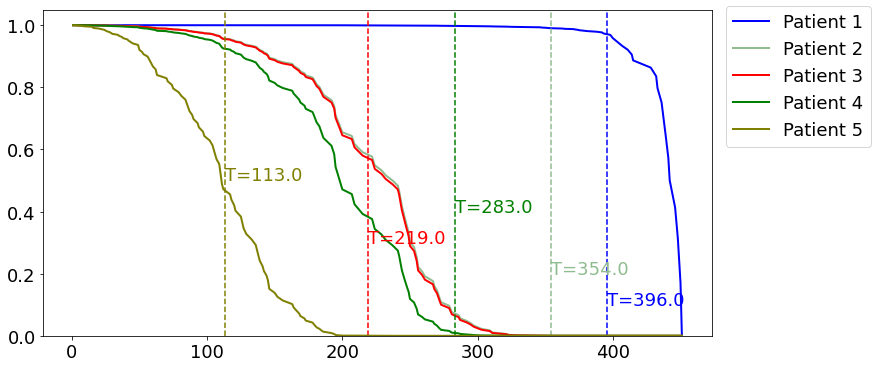

In [10]:
cs=['blue','darkseagreen','red','green','olive','cyan','tan','silver','purple','fuchsia','chocolate','darkcyan','aqua','pink','orange','bisque','lightsteelblue']

# Randomly extracting a data-point that experienced an event 
choices = np.argwhere((event_test==1.)&(time_test>=1)).flatten()
k_list = np.random.choice( choices, 5,replace=False)

for seed_i in np.arange(seed_num):
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Saving the time of event
    for i in np.arange(len(k_list)):
        k=k_list[i]
        t = time_test[k]

        # Computing the Survival function for all times t
        predicted = models[seed_i].predict_survival(X_test.values[k, :]).flatten()

        # Displaying the functions
        plt.plot(models[seed_i].times, predicted, color=cs[i], label='Patient '+str(i+1), lw=2)
    
        # Actual time
        plt.axvline(x=t, color=cs[i], ls ='--')
        ax.annotate('T={:.1f}'.format(t), xy=(t, 0.5), xytext=(t, (0.1+i/10)), fontsize=18,color=cs[i])

    plt.legend(loc=[1.02,0.58],fontsize=18, ncol=1)
    plt.ylim(0, 1.05)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.show()

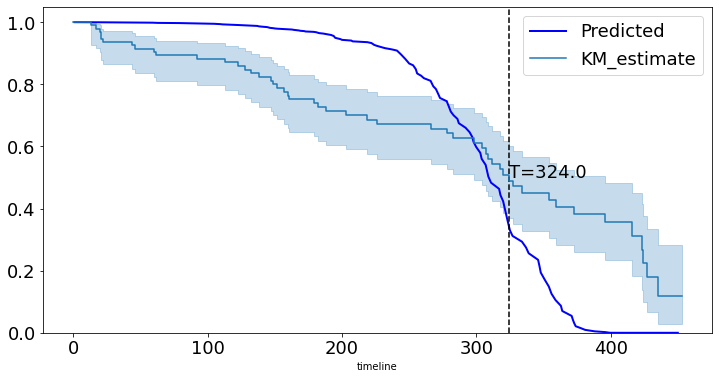

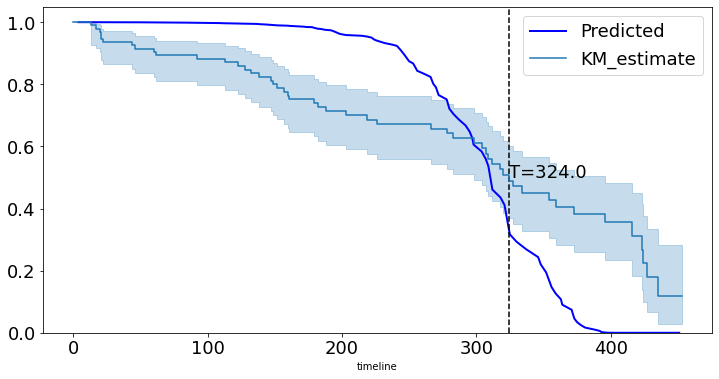

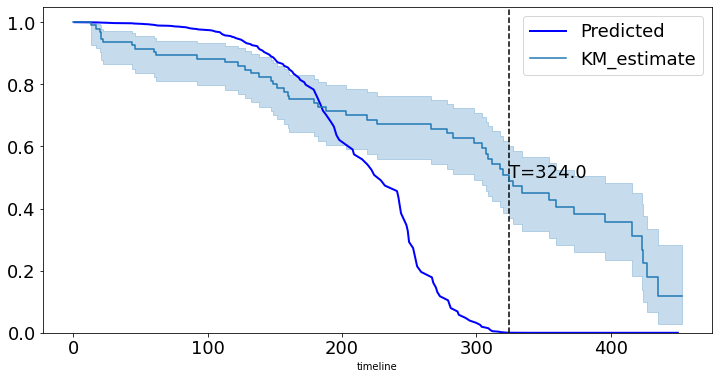

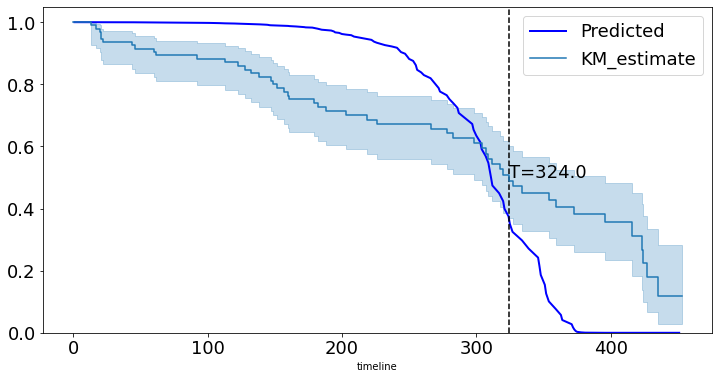

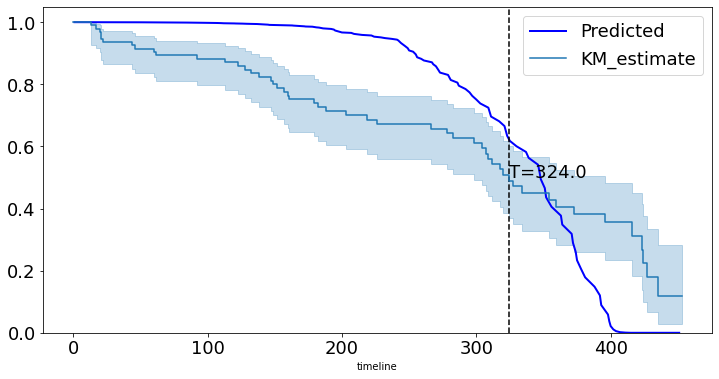

In [11]:
# Randomly extracting a data-point that experienced an event 
choices = np.argwhere((event_test==1.)&(time_test>=1)).flatten()
k = np.random.choice( choices, 1)[0]
    
for seed_i in np.arange(seed_num):
    
    kmf = KaplanMeierFitter()
    fig, ax = plt.subplots(figsize=(12, 6))

    # Saving the time of event
    t = time_test[k]

    # Computing the Survival function for all times t
    predicted = models[seed_i].predict_survival(X_test.values[k, :]).flatten()

    # Displaying the functions
    plt.plot(models[seed_i].times, predicted, color='blue', label='Predicted', lw=2)

    # Actual time
    plt.axvline(x=t, color='black', ls ='--')
    ax.annotate('T={:.1f}'.format(t), xy=(t, 0.5), xytext=(t, 0.5), fontsize=18)

    kmf.fit(time_test, event_observed=event_test)
    ax = kmf.plot_survival_function(ax=ax)

    # Show everything
    plt.legend(fontsize=18)
    plt.ylim(0, 1.05)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.show()

In [12]:
# Randomly extracting a data-point that experienced an event 
choices = np.argwhere((event_test==1.)&(time_test>=1)).flatten()
k = np.random.choice(choices, 1)[0]

# Saving the time of event
t = time_test[k]

predicted_list=[]
time_set={'Nan'}

for seed_i in np.arange(seed_num):
    # Computing the Survival function for all times t
    predicted = models[seed_i].predict_survival(X_test.values[k, :]).flatten()
    time=models[seed_i].times

    predicted_list.append(dict(zip(time,predicted)))
    time_set.update(set(time))

average_time_predicted_dict={}
for time_set_i in time_set:
    predicted_value=[]
    for seed_i in np.arange(seed_num):
        if time_set_i in predicted_list[seed_i].keys():
            predicted_value.append(predicted_list[seed_i][time_set_i])
    if len(predicted_value)>0:
        average_time_predicted_dict[time_set_i]=[np.mean(predicted_value),np.std(predicted_value)]
        
average_time_predicted={}
for i in sorted (average_time_predicted_dict.keys()) : 
    average_time_predicted[i]=average_time_predicted_dict[i]

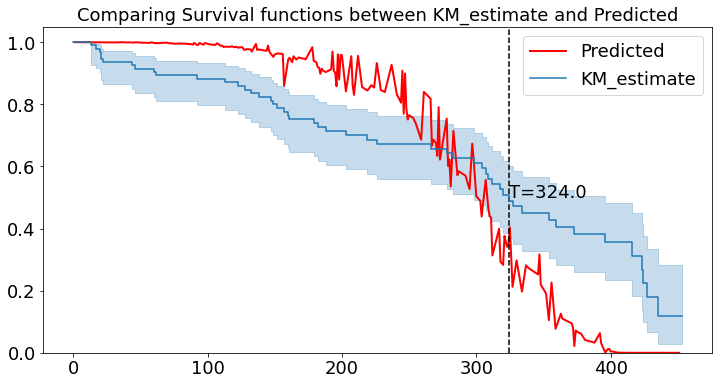

In [13]:
kmf = KaplanMeierFitter()
fig, ax = plt.subplots(figsize=(12, 6))

# Displaying the functions
plt.plot(list(average_time_predicted.keys()), np.array(list(average_time_predicted.values()))[:,0], color='red', label='Predicted', lw=2)

# Actual time
plt.axvline(x=t, color='black', ls ='--')
ax.annotate('T={:.1f}'.format(t), xy=(t, 0.5), xytext=(t, 0.5), fontsize=18)

kmf.fit(time_test, event_observed=event_test)
ax = kmf.plot_survival_function(ax=ax)

# Show everything
title = "Comparing Survival functions between KM_estimate and Predicted"
plt.legend(fontsize=18)
plt.title(title, fontsize=18)
plt.ylim(0, 1.05)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel("",fontsize=18)
plt.show()

In [14]:
models[0].model

NeuralNet(
  (model): Sequential(
    (0): Linear(in_features=272, out_features=150, bias=True)
    (1): BentIdentity()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=150, out_features=1, bias=True)
  )
)

In [15]:
feature_importace_list=[]
first_layer_weight_list=[]
for seed_i in np.arange(seed_num):
    first_layer_weight_=np.array(np.transpose(models[seed_i].model.state_dict()['model.0.weight']))
    feature_importace_=np.linalg.norm(first_layer_weight_,1, axis=1)
    first_layer_weight_list.append(first_layer_weight_)
    feature_importace_list.append(feature_importace_)

In [16]:
feature_importace=np.mean(np.array(feature_importace_list),axis=0)

In [17]:
column_names

['NACCREAS',
 'NACCREFR',
 'BIRTHMO',
 'BIRTHYR',
 'SEX',
 'HISPANIC',
 'HISPOR',
 'RACE',
 'RACESEC',
 'RACETER',
 'PRIMLANG',
 'EDUC',
 'MARISTAT',
 'NACCLIVS',
 'INDEPEND',
 'RESIDENC',
 'HANDED',
 'NACCNINR',
 'NACCFAM',
 'NACCMOM',
 'NACCDAD',
 'NACCFADM',
 'NACCFFTD',
 'ANYMEDS',
 'NACCSTYR',
 'NACCTIYR',
 'MEMORY',
 'ORIENT',
 'JUDGMENT',
 'COMMUN',
 'HOMEHOBB',
 'PERSCARE',
 'CDRSUM',
 'DECSUB',
 'DECIN',
 'COGMEM',
 'COGJUDG',
 'COGLANG',
 'COGVIS',
 'COGATTN',
 'COGOTHR',
 'NACCCOGF',
 'COGMODE',
 'DECAGE',
 'BEAPATHY',
 'BEDEP',
 'BEVHALL',
 'BEAHALL',
 'BEDEL',
 'BEDISIN',
 'BEIRRIT',
 'BEAGIT',
 'BEPERCH',
 'BEOTHR',
 'NACCBEHF',
 'BEMODE',
 'MOGAIT',
 'MOFALLS',
 'MOTREM',
 'MOSLOW',
 'NACCMOTF',
 'MOMODE',
 'COURSE',
 'FRSTCHG',
 'NORMCOG',
 'DEMENTED',
 'NACCPPA',
 'NACCBVFT',
 'NACCLBDS',
 'NACCTMCI',
 'NACCMCIL',
 'NACCMCIA',
 'NACCMCIE',
 'NACCMCIV',
 'NACCMCII',
 'IMPNOMCI',
 'NACCALZD',
 'NACCALZP',
 'NACCLBDE',
 'NACCLBDP',
 'PARK',
 'PSP',
 'PSPIF',
 'CORT',
 'CO

In [18]:
k=100
p_path="./feature_selection.csv"

top_k=heapq.nlargest(k, range(len(feature_importace)), feature_importace.take)

In [19]:
write_to_csv(np.array(top_k).reshape(1,np.array(top_k).shape[0]),p_path)

top_k

[112,
 116,
 115,
 270,
 74,
 27,
 30,
 269,
 41,
 75,
 43,
 28,
 204,
 32,
 51,
 49,
 42,
 36,
 148,
 220,
 26,
 259,
 209,
 156,
 107,
 81,
 119,
 125,
 207,
 25,
 205,
 129,
 153,
 34,
 206,
 159,
 151,
 141,
 1,
 4,
 10,
 103,
 16,
 105,
 140,
 128,
 3,
 189,
 246,
 131,
 217,
 267,
 221,
 240,
 170,
 255,
 97,
 251,
 80,
 268,
 39,
 50,
 63,
 225,
 11,
 53,
 55,
 167,
 29,
 211,
 104,
 52,
 155,
 2,
 130,
 33,
 173,
 262,
 146,
 135,
 212,
 14,
 5,
 265,
 271,
 198,
 160,
 48,
 216,
 139,
 133,
 226,
 245,
 137,
 99,
 247,
 57,
 89,
 92,
 260]

In [20]:
write_to_csv(feature_importace[top_k].reshape(1,feature_importace[top_k].shape[0]),p_path)

feature_importace[top_k]

array([14.322456 , 12.106934 , 10.807439 , 10.788887 , 10.751726 ,
       10.341844 , 10.023371 , 10.014417 ,  9.936322 ,  9.870123 ,
        9.8536   ,  9.813589 ,  9.803534 ,  9.782384 ,  9.780401 ,
        9.778327 ,  9.777309 ,  9.76678  ,  9.766761 ,  9.708519 ,
        9.663257 ,  9.598491 ,  9.592445 ,  9.511606 ,  9.508601 ,
        9.501509 ,  9.493491 ,  9.479111 ,  9.47812  ,  9.468664 ,
        9.461764 ,  9.453256 ,  9.437846 ,  9.42342  ,  9.416649 ,
        9.402781 ,  9.399274 ,  9.395696 ,  9.385157 ,  9.383703 ,
        9.380037 ,  9.377123 ,  9.368479 ,  9.362936 ,  9.359945 ,
        9.350316 ,  9.332371 ,  9.330615 ,  9.328897 ,  9.322213 ,
        9.321226 ,  9.31995  ,  9.318445 ,  9.3166895,  9.313078 ,
        9.306445 ,  9.304358 ,  9.29924  ,  9.296267 ,  9.293022 ,
        9.292645 ,  9.291292 ,  9.291002 ,  9.280934 ,  9.275735 ,
        9.275618 ,  9.269844 ,  9.265071 ,  9.262869 ,  9.258204 ,
        9.257226 ,  9.254026 ,  9.252947 ,  9.25158  ,  9.2513

In [21]:
write_to_csv(np.array(column_names[:-2])[top_k].reshape(1,np.array(column_names[:-2])[top_k].shape[0]),p_path)

np.array(column_names[:-2])[top_k]

array(['NACCAGEB', 'NACCAGE', 'NACCIDEM', 'NACCDAGE', 'NACCMCII',
       'ORIENT', 'HOMEHOBB', 'NPFAUT', 'NACCCOGF', 'IMPNOMCI', 'DECAGE',
       'JUDGMENT', 'NPPATH', 'CDRSUM', 'BEAGIT', 'BEDISIN', 'COGMODE',
       'COGJUDG', 'NPGRHA', 'NPHIPSCL', 'MEMORY', 'NACCDOWN', 'NPPATH5',
       'NPHISMB', 'COGOTH', 'PSP', 'NACCAC', 'NACCANGI', 'NPPATH3',
       'NACCTIYR', 'NACCNEC', 'NACCDBMD', 'NPABAN', 'DECIN', 'NPPATH2',
       'NPHIST', 'NACCAVAS', 'NPPMIH', 'NACCREFR', 'SEX', 'PRIMLANG',
       'DYSILL', 'HANDED', 'MEDS', 'NACCNE4S', 'NACCCCBS', 'BIRTHYR',
       'NPHEMO3', 'NPPDXB', 'NACCEMD', 'NACCLEWY', 'NACCCSFP', 'NPFTDTAU',
       'NPTDPA', 'NPINF1B', 'NPPDXK', 'DEP', 'NPPDXG', 'PARK', 'NPBNKF',
       'COGATTN', 'BEIRRIT', 'FRSTCHG', 'NACCPROG', 'EDUC', 'BEOTHR',
       'BEMODE', 'NACCAMY', 'COMMUN', 'NPPATH7', 'DYSILLIF', 'BEPERCH',
       'NPTDPAN', 'BIRTHMO', 'NACCDIUR', 'DECSUB', 'NPINF2A', 'NACCOTHP',
       'NPGRCCA', 'NACCNSD', 'NPPATH8', 'INDEPEND', 'HISPANIC',
       'N

In [22]:
np.array(column_names[:-2]).shape

(272,)

In [23]:
first_layer_weight=np.mean(np.array(first_layer_weight_list),axis=0)

In [24]:
first_layer_weight.shape

(272, 150)

In [25]:
first_layer_weight

array([[-0.03317343, -0.07252783, -0.0158869 , ..., -0.03186123,
         0.02230176, -0.01566114],
       [-0.0055363 ,  0.02133837, -0.00387376, ..., -0.01330417,
        -0.03329135, -0.01037927],
       [ 0.06077351, -0.01416273,  0.06050035, ...,  0.02047635,
        -0.00193573,  0.0186135 ],
       ...,
       [-0.02960298, -0.00461689,  0.01054462, ..., -0.03676243,
        -0.01446031, -0.05301996],
       [-0.06200017, -0.02801411, -0.0049501 , ..., -0.04421501,
        -0.08914068,  0.02953368],
       [ 0.0314666 , -0.0117321 ,  0.019727  , ...,  0.03960431,
         0.00160417,  0.03240922]], dtype=float32)

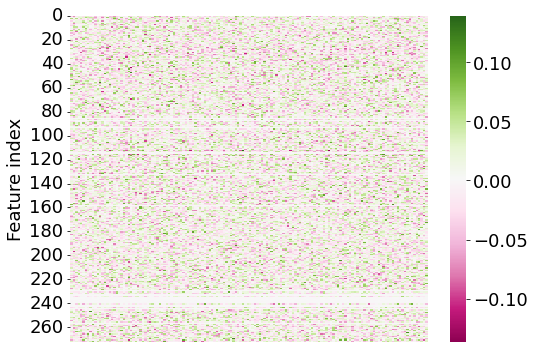

In [26]:
mn, mx = first_layer_weight.min(), first_layer_weight.max()

fig, ax = plt.subplots(figsize = (8,6))
heatmp=sns.heatmap(first_layer_weight, cmap='PiYG')
cbar = heatmp.collections[0].colorbar
# here set the labelsize by 18
cbar.ax.tick_params(labelsize=18)
plt.xlabel('')
plt.xticks([])
plt.yticks(np.arange(0,np.array(column_names[:-2]).shape[0],20),np.arange(0,np.array(column_names[:-2]).shape[0],20),fontsize=18)
plt.ylabel('Feature index',fontsize=18)
plt.show()

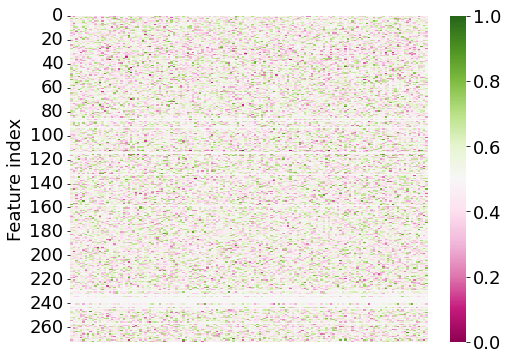

In [27]:
mn, mx = first_layer_weight.min(), first_layer_weight.max()
first_layer_weight_scaled = (first_layer_weight - mn) / (mx - mn)

fig, ax = plt.subplots(figsize = (8,6))
heatmp=sns.heatmap(first_layer_weight_scaled, cmap='PiYG', vmin=0, vmax=1)
cbar = heatmp.collections[0].colorbar
# here set the labelsize by 18
cbar.ax.tick_params(labelsize=18)
plt.xlabel('')
plt.xticks([])
plt.yticks(np.arange(0,np.array(column_names[:-2]).shape[0],20),np.arange(0,np.array(column_names[:-2]).shape[0],20),fontsize=18)
plt.ylabel('Feature index',fontsize=18)
plt.show()